# Import Libraries

In [1]:
import sys
import os

# Move one level up from "experiments/" to the project root (MLGroup105)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Path to src/
SRC_DIR = os.path.join(BASE_DIR, "src")

# Ensure "src/" is in sys.path
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)  # Ensure src/ is the first path

# Debugging: Print paths
print(f"Project Root: {BASE_DIR}")
print(f"Added to sys.path: {sys.path[0]}")


Project Root: /Users/hidde/Documents/STUDIE/Pre Master BA/Periode 4/ML/MLGroup105
Added to sys.path: /Users/hidde/Documents/STUDIE/Pre Master BA/Periode 4/ML/MLGroup105/src


In [2]:
import torch
from timeit import default_timer as timer
from model import AgePredictionCNN
from train import train
from evaluate import plot_loss_and_accuracy_curves, predict, evaluate_predictions
from data import AgeDatasetManager
from config import device
import torch.nn as nn
from torchvision import transforms


# Load and Prepare Data

In [ ]:
# Define transformations for training and testing data
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize dataset manager and get DataLoaders
dataset_manager = AgeDatasetManager(
    # age_bins=[0, 18, 25, 70], 
    # age_labels=['Not Old Enough', 'Check ID', 'Old Enough']
    age_bins=[0, 25, 70], 
    age_labels=['Check ID', 'Old Enough'],
    label_dtype="long" #long for CrossEntropyLoss, float32 for BCEWithLogitsLoss
)

train_loader, val_loader, test_loader = dataset_manager.get_data_loaders(
    train_size=0.7, val_size=0.15, test_size=0.15, batch_size=16,
    train_transform=train_transform, test_transform=test_transform
)

age_idx = {label: i for i, label in enumerate(dataset_manager.age_labels)}


# Initialize the Model

In [ ]:
# Initialize the model
CNN_model = AgePredictionCNN(num_age_bins=len(age_idx)).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)

# Class weights for imbalanced dataset
# class_weights = torch.tensor([5.15, 7.37, 1.49]).to(device)
# age_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
class_weights = torch.tensor([3.0, 1.0], dtype=torch.float32).to(device)
age_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)




#  Train the Model

In [5]:
EPOCHS = 10

start_time = timer()

# Train the model
model_results = train(
    model=CNN_model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    optimizer=optimizer,
    age_loss_fn=age_loss_fn,
    epochs=EPOCHS,
    device=device
)

end_time = timer()
print(f'Total Training Time: {end_time - start_time:.3f} seconds')



Epoch 1/10
Train Loss: 0.8018 | Train Acc: 46.3217%
Test Loss: 0.6063 | Test Acc: 57.4927%



Epoch 2/10
Train Loss: 0.5979 | Train Acc: 71.3256%
Test Loss: 0.5248 | Test Acc: 67.1966%



Epoch 3/10
Train Loss: 0.5590 | Train Acc: 74.2163%
Test Loss: 0.5101 | Test Acc: 75.7858%



Epoch 4/10
Train Loss: 0.5369 | Train Acc: 74.0706%
Test Loss: 0.4865 | Test Acc: 78.7098%



Epoch 5/10
Train Loss: 0.5153 | Train Acc: 75.8388%
Test Loss: 0.4637 | Test Acc: 74.7076%



Epoch 6/10
Train Loss: 0.5070 | Train Acc: 74.9370%
Test Loss: 0.4750 | Test Acc: 73.6659%



Epoch 7/10
Train Loss: 0.4975 | Train Acc: 77.6111%
Test Loss: 0.4645 | Test Acc: 69.7734%



Epoch 8/10
Train Loss: 0.4771 | Train Acc: 77.9064%
Test Loss: 0.4655 | Test Acc: 77.8326%



Epoch 9/10
Train Loss: 0.4654 | Train Acc: 76.6147%
Test Loss: 0.4351 | Test Acc: 76.4803%



Epoch 10/10
Train Loss: 0.4600 | Train Acc: 76.7407%
Test Loss: 0.4330 | Test Acc: 73.6111%
Total Training Time: 786.201 seconds


# Evaluate the Model

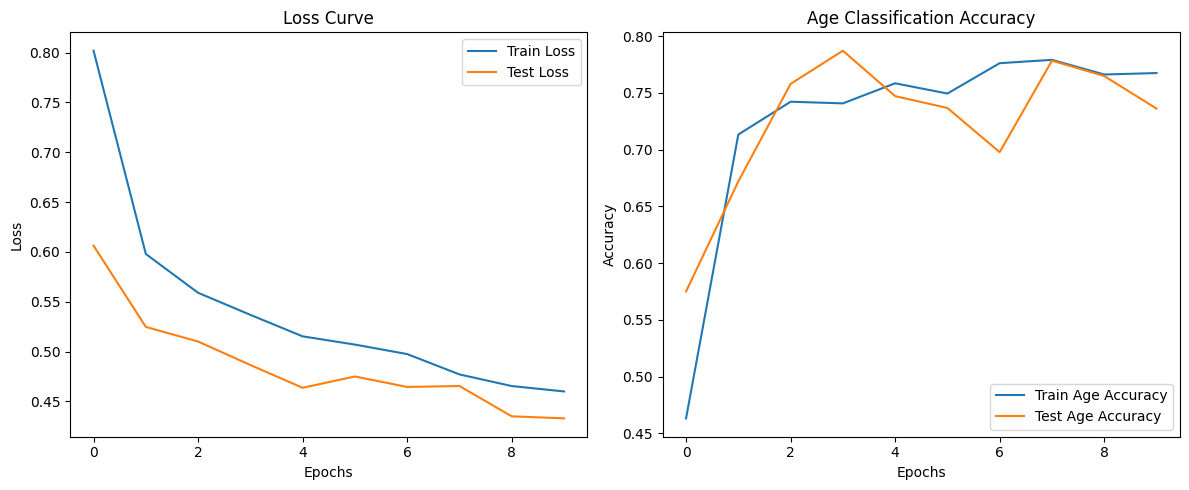

              precision    recall  f1-score   support

    Check ID       0.55      0.84      0.67       580
  Old Enough       0.90      0.68      0.77      1232

    accuracy                           0.73      1812
   macro avg       0.73      0.76      0.72      1812
weighted avg       0.79      0.73      0.74      1812



In [6]:
# Plot loss and accuracy curves
plot_loss_and_accuracy_curves(model_results)

# Make predictions
eval_results = predict(model=CNN_model, dataloader=test_loader)

# Generate classification report
class_report = evaluate_predictions(eval_results, age_idx)
print(class_report)


# Experiment Documentation
### Hyperparameters:
- Learning Rate: 0.001
- Epochs: 10
- Batch Size: 16

### Changes Tested:
- Testing if 2 classes are better to predict than 3
- Still Used CrossEntropyLoss with class weights

### Results:
<!-- - Final Test Accuracy: 0.76% -->
<!-- - Observed better performance with weighted loss -->
<!-- - Check ID is still not presented in the classification_report -->